### Word2vec embedding

In [ ]:
# tokenizing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

word_tokens = []
for sentence in list(data.text):
  word_tokens.append(word_tokenize(str(sentence)))

# stopwords
stop = ['.', ',']
stop_words = stopwords.words('english') + stop

result = []

for word in word_tokens:
  temp = []
  for i in range(len(word)):
    if word[i] not in stop_words:
      temp.append(word[i])

  result.append(temp)

In [ ]:
# word2vec
from gensim.models.word2vec import Word2Vec

model = Word2Vec(result,        
                 sg=1,         
                 size=100,     
                 window=3,    
                 min_count=2,
                 workers=4,
                 iter=5)

In [ ]:
#model.save('word2vec.model')

In [25]:
from gensim.models import Word2Vec
model = Word2Vec.load('/content/drive/MyDrive/컨퍼런스/word2vec.model')
print(model.wv.most_similar("love", topn=5))
print(model.wv.most_similar("sad", topn=5))
print(model.wv.most_similar("girl", topn=5))

[('hate', 0.670912504196167), ('loved', 0.6641808748245239), ('loves', 0.6218445897102356), ('loving', 0.5904812812805176), ('xoxo', 0.5817274451255798)]
[('heartbroken', 0.767870306968689), ('gloomy', 0.7636538743972778), ('emo', 0.7579500675201416), ('lonely', 0.7500572204589844), ('depressed', 0.74977707862854)]
[('boy', 0.8238763809204102), ('lady', 0.7907259464263916), ('guy', 0.7830477356910706), ('puppy', 0.7705798149108887), ('girls', 0.7678708434104919)]


### LSTM model

In [26]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [27]:
# data load
data = pd.read_csv("/content/drive/MyDrive/컨퍼런스/result.csv")
data.text = data.text.astype(str)
data.head()

,text,anger,disgust,fear,joy,sadness,surprise,no emotion
0,The kitchen stinks .,0,1,0,0,0,0,0
1,I'll throw out the garbage .,0,0,0,0,0,0,1
2,"So Dick , how about getting some coffee for to...",0,0,0,1,0,0,0
3,Coffee ? I don ’ t honestly like that kind of ...,0,1,0,0,0,0,0
4,"Come on , you can at least try a little , besi...",0,0,0,0,0,0,1


In [28]:
# train, test split
Y = data.copy().drop(columns='text').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(data['text'], Y, test_size=0.2, shuffle=True, random_state=200)

In [29]:
# preprocessing
token = Tokenizer()
token.fit_on_texts(list(X_train) + list(X_test))

X_train_pad = pad_sequences(token.texts_to_sequences(X_train), padding='pre', maxlen=200)
X_test_pad = pad_sequences(token.texts_to_sequences(X_test), padding='pre', maxlen=200)

In [30]:
# Word2vec embedding
vocab_size = len(token.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

def get_vector(word):
    if word in model:
        return model[word]
    else:
        return None

for word, i in token.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [ ]:
print(model['nice'])

In [ ]:
print(embedding_matrix[token.word_index['nice']])

In [31]:
# LSTM modeling
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=X_train_pad.shape[1], trainable=False))
model.add(LSTM(100, dropout=0.2, return_sequences=True))
model.add(LSTM(50, dropout=0.3))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          5634800   
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 357       
Total params: 5,745,757
Trainable params: 110,957
Non-trainable params: 5,634,800
_________________________________________________________________
None


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=64, verbose=1, validation_split=0.2, callbacks=[early_stopping])

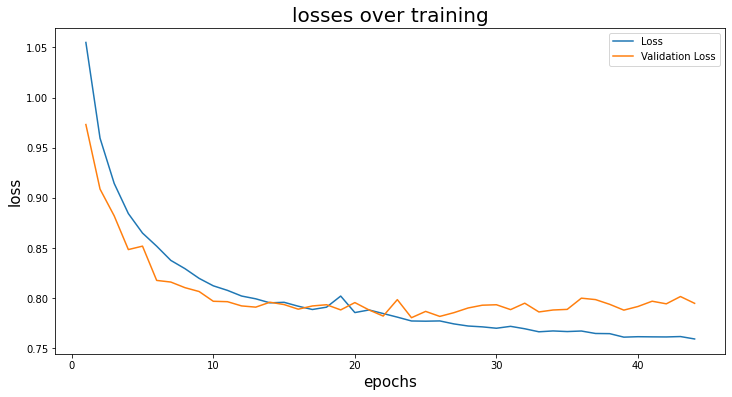

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(44)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(44)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

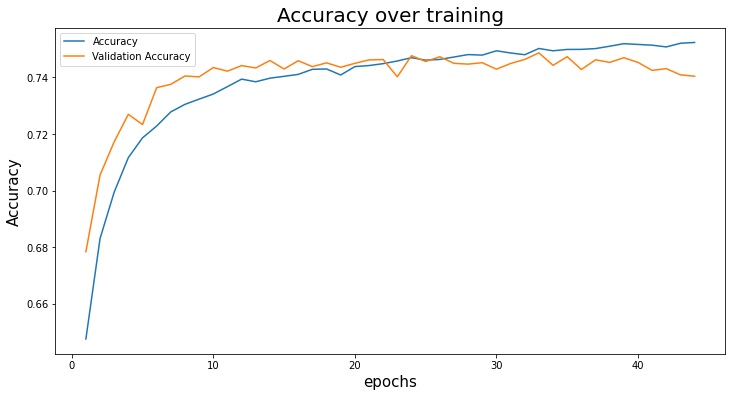

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(44)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(44)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()

In [18]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/컨퍼런스/model.h5")
#model.save("model.h5")

In [ ]:
# predict
emotion = model.predict(X_test_pad)
emo = np.round(emotion)

sent_to_emotion = {0:'anger', 1:'disgust', 2:'fear', 3:'joy', 4:'sadness', 5:'surprise', 6:'no emotion'}

x = []
for i in range(len(emo)):
    x.append(np.argmax(emo[i]))

actual = []
for i in range(len(y_test)):
    actual.append(np.argmax(y_test[i]))

In [ ]:
result_data = pd.DataFrame({"Text": X_test.reset_index(drop=True), "Actual": pd.Series(actual).map(sent_to_emotion),
                            "Predict": pd.Series(x).map(sent_to_emotion)})
result_data.head(20)

,Text,Actual,Predict
0,im feeling quite distressed about the amount o...,fear,fear
1,oh i stand corrected half a million people is ...,anger,anger
2,i feel insulted as if he feels he doesn t have...,anger,anger
3,You saw a ghost ? When ?,no emotion,no emotion
4,Well I wish you luck .,no emotion,no emotion
5,"Hello , how can I be of service ?",no emotion,no emotion
6,That ’ s a hefty amount . But that should have...,no emotion,no emotion
7,i feel a strange type of peace with this go ar...,surprise,fear
8,sounds like your new chapter has started alrea...,joy,joy
9,i am sorry you are going through that i wish i...,sadness,sadness


In [ ]:
n = 0
for i in range(len(result_data)):
  if result_data['Actual'][i] == result_data['Predict'][i]:
    n += 1

print((n / len(result_data)) * 100)

67.54791219965074


In [ ]:
# input textt
text = []
text.append(str(input("텍스트를 영어로 입력하세요: ")))
token.fit_on_texts(text)
text_pre = pad_sequences(token.texts_to_sequences(text), padding='pre', maxlen=200)
pre = model.predict(text_pre)
print("해당 텍스트의 감정은 " + pd.Series(np.argmax(np.round(pre))).map(sent_to_emotion) + " 입니다.")